<a href="https://colab.research.google.com/github/naemililia/masterthesis/blob/main/train_contrastive_learning_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I am taking the dataloaders etc from my pretext task (where i took the base code for it from tehs enfloods authors).

the contrastive learning code for simclr I am taking from here:
https://medium.com/the-owl/simclr-in-pytorch-5f290cb11dd7

## 0. Installations and imports

In [ ]:
!pip install rasterio

In [ ]:
# connect drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# create a folder for model checkpoints

%cd /home
!sudo mkdir checkpoints

/home
mkdir: cannot create directory ‘checkpoints’: File exists


In [ ]:
import rasterio
import numpy as np
import pandas as pd
import shutil, time, requests, copy
from sklearn.model_selection import train_test_split
import os
import csv
from PIL import Image
from scipy.ndimage import zoom
import torch
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from matplotlib import pyplot as plt
#import segmentation_models_pytorch as smp
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.display import display

## 1. Load Senfloods data

In [ ]:
from google.colab import auth
auth.authenticate_user()

!curl https://sdk.cloud.google.com | bash

!gcloud init

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-identity/2021-04-20/endpoint-rule-set-1.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-identity/2021-04-20/paginators-1.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-identity/2021-04-20/service-2.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-media-pipelines/2021-07-15/endpoint-rule-set-1.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-media-pipelines/2021-07-15/paginators-1.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-media-pipelines/2021-07-15/service-2.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-meetings/2021-07-15/endpoint-rule-set-1.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-meetings/2021-07-15/paginators-1.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-meetings/2021-07-15/service-2.json
google-cloud-sdk/lib/third_party/botocore/dat

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  36618      0 --:--:-- --:--:-- --:--:-- 36930
OK
46 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: http://packages.cloud.google.com/apt/dists/gcsfuse-bionic/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 46 not upgraded.
Need to get 10.4 MB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 121920 files and directories currently installed.)
Preparing to unpack .../gcsfuse_2.0.1_amd64.deb ...
Unpacking gcsfuse (2.0.1) ...
Setting up gcsfuse (2.0.1) ...


In [ ]:
%cd /home
!sudo mkdir checkpoints

/home
mkdir: cannot create directory ‘checkpoints’: File exists


In [ ]:
# first load the raw satellite data from the S1 weakly labeled dataset of senfloods

!sudo mkdir files
!sudo mkdir files/S1weak_all

!gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak files/S1weak_all


both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
Starting synchronization...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1068962_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1163442_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1274097_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1469741_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1608856_S1Weak.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/WeaklyLabeled/S1Weak/Bolivia_1966339_S1Weak.tif...
Copying gs://sen1floods11/v1.1

## 2. Prepare the dataloaders

In [ ]:
# the labels are saved on my google drive
BUILT_path_senfloods = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/BUILT/Sen1floods11/'
POP_path_senfloods = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/POP/Sen1floods11/'
LC_path_senfloods = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/LC/Sen1floods11/'


test_train_images_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/flood/batch_1/'
test_val_images_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/flood/batch_2/'




In [ ]:
train_data_subset = pd.read_csv('/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/train_data_subset.csv')
train_data_subset

,filename,label
0,Paraguay_9566973_S1Weak.tif,Paraguay_9566973_S1Weak_label.npy
1,India_3385853_S1Weak.tif,India_3385853_S1Weak_label.npy
2,India_5962075_S1Weak.tif,India_5962075_S1Weak_label.npy
3,USA_2091939_S1Weak.tif,USA_2091939_S1Weak_label.npy
4,USA_9494541_S1Weak.tif,USA_9494541_S1Weak_label.npy
...,...,...
295,Pakistan_6114632_S1Weak.tif,Pakistan_6114632_S1Weak_label.npy
296,USA_1147312_S1Weak.tif,USA_1147312_S1Weak_label.npy
297,Colombia_1131006_S1Weak.tif,Colombia_1131006_S1Weak_label.npy
298,Colombia_8600107_S1Weak.tif,Colombia_8600107_S1Weak_label.npy


In [ ]:
val_data_subset = pd.read_csv('/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/val_data_subset.csv')
val_data_subset

,filename,label
0,Sri-Lanka_3153937_S1Weak.tif,Sri-Lanka_3153937_S1Weak_label.npy
1,India_7089682_S1Weak.tif,India_7089682_S1Weak_label.npy
2,Paraguay_7990252_S1Weak.tif,Paraguay_7990252_S1Weak_label.npy
3,Sri-Lanka_3675661_S1Weak.tif,Sri-Lanka_3675661_S1Weak_label.npy
4,India_8959582_S1Weak.tif,India_8959582_S1Weak_label.npy
...,...,...
70,Colombia_565072_S1Weak.tif,Colombia_565072_S1Weak_label.npy
71,India_8862939_S1Weak.tif,India_8862939_S1Weak_label.npy
72,Mekong_288773_S1Weak.tif,Mekong_288773_S1Weak_label.npy
73,Somalia_1595869_S1Weak.tif,Somalia_1595869_S1Weak_label.npy


In [ ]:
df_test_train = pd.read_csv('/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/test_train_filenames.csv')
df_test_train

,filename,label
0,Colombia_3986001_S1Weak.tif,Colombia_3986001_S1Weak_label.npy
1,Ghana_3527966_S1Weak.tif,Ghana_3527966_S1Weak_label.npy
2,India_1915393_S1Weak.tif,India_1915393_S1Weak_label.npy
3,India_1796024_S1Weak.tif,India_1796024_S1Weak_label.npy
4,Mekong_34098_S1Weak.tif,Mekong_34098_S1Weak_label.npy
5,Nigeria_2434449_S1Weak.tif,Nigeria_2434449_S1Weak_label.npy


In [ ]:
df_test_val = pd.read_csv('/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/test_val_filenames.csv')
df_test_val

,filename,label
0,Pakistan_2777402_S1Weak.tif,Pakistan_2777402_S1Weak_label.npy
1,Paraguay_9460560_S1Weak.tif,Paraguay_9460560_S1Weak_label.npy
2,Sri-Lanka_5335407_S1Weak.tif,Sri-Lanka_5335407_S1Weak_label.npy
3,USA_5510883_S1Weak.tif,USA_5510883_S1Weak_label.npy
4,Somalia_9757143_S1Weak.tif,Somalia_9757143_S1Weak_label.npy


In [ ]:
# functions needed for the loading of the data
# with contrastive learning i can only ever do one label type at a time

def getArrFlood(fname):
    """Load .tif data into array"""
    return rasterio.open(fname).read()

def download_flood_water_data_from_list(l):
  i = 0
  flood_data = []
  for (im_fname, mask_fname) in l:
    if not os.path.exists(im_fname):
      continue
    # load satellite image with rasterio
    arr_x = np.nan_to_num(getArrFlood(im_fname))

    arr_x = np.clip(arr_x, -50, 1)
    arr_x = (arr_x + 50) / 51

    # load label with numpy
    arr_y = np.load(mask_fname)

    if i % 100 == 0:
      print(im_fname, mask_fname)
    i += 1
    flood_data.append((arr_x,arr_y))

  return flood_data

def load_flood_train_data(input_root, label_root):
  fname = "/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/S1weak_train_filenames_final.csv" # S1weak_train_filenames_final, train_data_subset
  training_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      training_files.append(tuple((input_root+line[0], label_root+line[1])))

  return download_flood_water_data_from_list(training_files)

def load_flood_valid_data(input_root, label_root):
  fname = "/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/S1weak_val_filenames_final.csv" # S1weak_val_filenames_final, val_data_subset
  validation_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      validation_files.append(tuple((input_root+line[0], label_root+line[1])))

  return download_flood_water_data_from_list(validation_files)

def load_flood_test_data(input_root, label_root):
  #fname = "/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/test_val_filenames.csv"
  testing_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      testing_files.append(tuple((input_root+line[0], label_root+line[1])))

  return download_flood_water_data_from_list(testing_files)



In [ ]:
# functions needed for the processing of the labels

quantiles_built = [1.000e+00, 1.600e+01, 8.000e+01, 2.380e+02, 6.600e+02, 8.556e+03]

def make_BUILT_categorical(array_label):
  categorical_label = np.digitize(array_label, quantiles_built, right=True)

  categorical_label = categorical_label.astype(np.uint8)
  return categorical_label

# possible LC label values
possible_label_vals = [0,  20,  30,  40,  50,  60,  80,  90, 111, 112, 114, 115, 116,
        121, 122, 124, 126, 200]

# create a mapping dictioanry
label_to_class_id = {label: idx for idx, label in enumerate(possible_label_vals)}
vectorized_map = np.vectorize(label_to_class_id.get, otypes=[np.uint32])

def class_id_transformation_LC(array_label):
  """
  Transforms all LC label values to class_id values. The class IDs are defined above
  """
  return vectorized_map(array_label)

def resize_the_label_for_senfloods(array_label):
  """
  Resizes each label to the Senfloods image size of 512 x 512.
  All variables are resized with order = 0, a nearest neighbor technique

  """
  original_shape = array_label.shape

  new_shape = (512, 512) # this is a senfloods specific function

  zoom_factors = [n / o for n, o in zip(new_shape, original_shape)]

  # if AUXILIARY_DATASOURCE == 'BUILT' or AUXILIARY_DATASOURCE == 'POP':
  #   order = 1
  # elif AUXILIARY_DATASOURCE == 'LC':
  #   order = 0

  resized_label = zoom(array_label, zoom_factors, order = 0)

  return resized_label

In [ ]:
# the actual processing function for training data


def processAndAugment(data, label_type):
  """
  process for a single label, but depending on the label_type.

  for contrastive learning, the only transformation we want to do is a crop and resize (do i need the resize part?)
  no further color drop, color jitter or gaussian blur is needed, because the two types of data can already be thought of
  as highly augmented views of each other (Jain, wilson et al 2022)

  I dont think i need to resize if i immediately crop to a specified size
  """
  (x,y) = data
  im,label = x.copy(), y.copy()

  # make labels categorical and scale label
  if label_type == 'BUILT':
    #label = log_scale_label(label)
    #label = min_max_scale_BUILT(label)
    label = make_BUILT_categorical(label)
    #labels[0] = resize_the_label_for_senfloods(label)
  elif label_type == 'POP':
    #labels[0] = log_scale_label(labels[0])
    #labels[0] = min_max_scale_POP(labels[0])
    label = make_POP_categorical(label)
    #labels[0] = resize_the_label_for_senfloods(label)
  elif label_type == 'LC':
    label = class_id_transformation_LC(label)
    #labels[0] = resize_the_label_for_senfloods(label)

  # resize labels to 512 x 512
  label = resize_the_label_for_senfloods(label)

  # convert to PIL for easier transforms
  im1 = Image.fromarray(im[0])
  im2 = Image.fromarray(im[1])
  label = Image.fromarray(label.squeeze())

  # Get params for random transforms
  i, j, h, w = transforms.RandomCrop.get_params(im1, (256, 256))

  im1 = F.crop(im1, i, j, h, w)
  im2 = F.crop(im2, i, j, h, w)
  label = F.crop(label, i, j, h, w)


  norm = transforms.Normalize([0.7708, 0.6313], [0.0987, 0.1306]) # meand and std of S1weak trainign data
  im = torch.stack([transforms.ToTensor()(im1).squeeze(), transforms.ToTensor()(im2).squeeze()]) # tensor of size (2, 512, 512) (or 256x256 if we crop), still same values
  im = norm(im)
  label = torch.tensor(np.array(label))#.squeeze() # TODO: figure otu if i need the squeeze here

  return im, label


In [ ]:
# the processing function for validation data (similar to training processing)

def processValIm(data, label_type):
  (x,y) = data
  im,label = x.copy(), y.copy()

  if label_type == 'BUILT':
    #labels[0] = log_scale_label(labels[0])
    label = min_max_scale_BUILT(label)
    #label = make_BUILT_categorical(label)
    #labels[0] = resize_the_label_for_senfloods(labels[0])
  elif label_type == 'POP':
    #labels[0] = log_scale_label(labels[0])
    label = min_max_scale_POP(label)
    #label = make_POP_categorical(label)
    #labels[0] = resize_the_label_for_senfloods(labels[0])
  elif label_type == 'LC':
    label = class_id_transformation_LC(label)
    #labels[0] = resize_the_label_for_senfloods(labels[0])

  # resize labels to 512 x 512
  label = resize_the_label_for_senfloods(label)

  # convert to PIL for easier transforms
  im_c1 = Image.fromarray(im[0]).resize((512,512))
  im_c2 = Image.fromarray(im[1]).resize((512,512))
  label = Image.fromarray(label.squeeze()).resize((512,512))

  im_c1 = F.crop(im_c1, 128, 128, 256, 256)
  im_c2 = F.crop(im_c2, 128, 128, 256, 256)
  label = F.crop(label, 128, 128, 256, 256)

  norm = transforms.Normalize([0.7708, 0.6313], [0.0987, 0.1306]) # for S1weak_labels: (tensor([0.7708, 0.6313]), tensor([0.0987, 0.1306]))
  im = torch.stack([transforms.ToTensor()(im_c1).squeeze(), transforms.ToTensor()(im_c2).squeeze()])
  im = norm(im) # torch.Size([2, 256, 256])
  label = torch.tensor(np.array(label))

  return im, label

In [ ]:
# the dataset class i am using

class InMemoryDataset(torch.utils.data.Dataset):

  def __init__(self, data_list, preprocess_func, label_type):
    self.data_list = data_list
    self.preprocess_func = preprocess_func
    self.label_type = label_type

  def __getitem__(self, i):
    return self.preprocess_func(self.data_list[i], self.label_type)

  def __len__(self):
    return len(self.data_list)

In [ ]:
path_to_data = '/home/files/S1weak_all/'
label_type = 'LC'
path_to_label = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/'+ label_type +'/Sen1floods11/'

In [ ]:
# creating the dataloaders
train_data = load_flood_train_data(path_to_data, path_to_label)
train_dataset = InMemoryDataset(train_data, processAndAugment, label_type)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=None,
                  pin_memory=True, drop_last=True, timeout=0,
                  worker_init_fn=None)

/home/files/S1weak_all/Sri-Lanka_9986038_S1Weak.tif /content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/LC/Sen1floods11/Sri-Lanka_9986038_S1Weak_label.npy
/home/files/S1weak_all/Paraguay_5981526_S1Weak.tif /content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/LC/Sen1floods11/Paraguay_5981526_S1Weak_label.npy
/home/files/S1weak_all/India_6814345_S1Weak.tif /content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/LC/Sen1floods11/India_6814345_S1Weak_label.npy
/home/files/S1weak_all/Bolivia_2302262_S1Weak.tif /content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/LC/Sen1floods11/Bolivia_2302262_S1Weak_label.npy
/home/files/S1weak_all/Somalia_2475390_S1Weak.tif /content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/LC/Sen1floods11/Somalia_2475390_S1Weak_label.npy
/home/files/S1weak_all/Paraguay_2122908_S1Weak.tif /content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/LC/Sen1floods11/Paraguay_2122908_S1Weak_label.npy
/home/files/S1weak_all/Nigeria

In [ ]:
valid_data = load_flood_valid_data(path_to_data, path_to_label)
valid_dataset = InMemoryDataset(valid_data, processValIm, label_type)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, #collate_fn=lambda x: (torch.cat([a[0] for a in x], 0), torch.cat([a[1] for a in x], 0)),
                  pin_memory=True, drop_last=True, timeout=0,
                  worker_init_fn=None)

/home/files/S1weak_all/Spain_773144_S1Weak.tif /content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/LC/Sen1floods11/Spain_773144_S1Weak_label.npy
/home/files/S1weak_all/India_6572601_S1Weak.tif /content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/LC/Sen1floods11/India_6572601_S1Weak_label.npy
/home/files/S1weak_all/India_2069619_S1Weak.tif /content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/LC/Sen1floods11/India_2069619_S1Weak_label.npy
/home/files/S1weak_all/Sri-Lanka_1724917_S1Weak.tif /content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/LC/Sen1floods11/Sri-Lanka_1724917_S1Weak_label.npy
/home/files/S1weak_all/Bolivia_8578058_S1Weak.tif /content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/LC/Sen1floods11/Bolivia_8578058_S1Weak_label.npy
/home/files/S1weak_all/Mekong_1626389_S1Weak.tif /content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/data/LC/Sen1floods11/Mekong_1626389_S1Weak_label.npy
/home/files/S1weak_all/India_9825043_S1Weak.ti

## 3. Define the network, loss function & optimizer

SimCLR

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512), # 512 ist eine intermediate dimension um etwas komplexere representations zu lernen
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class TwoStrandModel(nn.Module):
    def __init__(self):
        super(TwoStrandModel, self).__init__()
        # Initialize ResNet-18 models, each input type gets its own encoder (but they start out to be the same one)
        self.encoder_im1 = self.create_encoder(num_input_channels=2)  # for SAR
        self.encoder_built = self.create_encoder(num_input_channels=1) # for BUILT or POP (might need a new model for LC, but actually not, because all teh classes are in the one channel)

        # Dimension of the ResNet-50 output before the fully connected layer
        feature_dim = 512 # 512 for resnet-18, 2048 for resnet50

        # Projection heads
        self.projection_im1 = ProjectionHead(input_dim=feature_dim, output_dim=128) # Jain, Wilson also use 128
        self.projection_built = ProjectionHead(input_dim=feature_dim, output_dim=128) # Jain, Wilson also use 128

    def create_encoder(self, num_input_channels):
        encoder = models.resnet18()#weights='IMAGENET1K_V1') # pretrained on Imagenet might have a good effect and could counteract our single GPU disadvantage (der medium article lässt hoffen)
        encoder.conv1 = nn.Conv2d(num_input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Remove the final fully connected layer
        encoder.fc = nn.Identity()
        return encoder

    def forward(self, im1, built):

        if built.dim() == 3 and built.shape[1] != 1:
            built = built.unsqueeze(1)  # Add a channel dimension

        # Pass inputs through their respective encoders
        features_im1 = self.encoder_im1(im1)
        features_built = self.encoder_built(built)

        # Pass through projection heads
        projected_im1 = self.projection_im1(features_im1)
        projected_built = self.projection_built(features_built)

        return projected_im1, projected_built


# # Example usage
# model = TwoStrandModel()
# criterion = ContrastiveLoss()

# # Model forward pass
# projected_im1, projected_built = model(im1, built)

# # Compute loss
# loss = criterion(projected_im1, projected_built)
# print('Loss:', loss.item())


In [ ]:
net = TwoStrandModel()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 226MB/s]


##Loss function

based on the medium article as well

In [ ]:
# loss acc. to medium article
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        # this is supposed to identify positive pairs
        self.mask = self.mask_correlated_samples(batch_size)

        # chatgpt: 'This sets up the cross-entropy loss for comparing the logits from concatenated positive and negative sample similarities against labels that are all zeros (indicating the first class is the correct class for all positive samples).'
        self.criterion = nn.CrossEntropyLoss(reduction="sum")


        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        # we have N entries in a batch, and we have two views of the same location: SAR and the aux info
        N = 2 * batch_size

        # chatgpt: Creates an N x N mask initialized to True, to later exclude specific pairs from being considered as negative samples.
        mask = torch.ones((N, N), dtype=bool)

        # chatgpt: Sets the diagonal elements of the mask to False (0 in a boolean context), ensuring that each example is not compared with itself.
        mask = mask.fill_diagonal_(0)

        # These lines set the mask to False for each pair of correlated samples (i.e., each original and its augmented version), ensuring they are not considered as negative pairs.
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0

        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        # chatgpt: results in 2N total embeddings
        z = torch.cat((z_i, z_j), dim=0)

        # chaptgpt: Calculates the cosine similarity matrix for all pairs of embeddings, scaled by the temperature. unsqueeze is used to make the tensors compatible for pairwise similarity computation.
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        # chatgpt: Extracts the similarities of correlated (positive) pairs z_i to z_j and z_j to z_i from the similarity matrix.
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)

        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        # chatgpt: Concatenates the similarities of positive pairs and reshapes them for compatibility with the loss function.
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)

        # chatgpt: Selects and reshapes the similarities of negative pairs as per the mask.
        negative_samples = sim[self.mask].reshape(N, -1)

        #SIMCLR

        # chatgpt: Creates labels, all set to 0, corresponding to the index of positive samples in concatenated logits. It ensures the labels are on the same device as the embeddings.
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()

        # chatgpt: Concatenates the positive samples with the negative samples to form the logits.
        logits = torch.cat((positive_samples, negative_samples), dim=1)

        # chatgpt: Calculates the cross-entropy loss and normalizes it by the number of pairs (N).
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [ ]:
criterion = SimCLR_Loss(batch_size=256, temperature=0.5)

#### Optimizer

the paper uses LARS optimizer, because it is good at handling the very huge batch sizes.

Now with rather small batch sizes of 256, it might be overkill and i could also go with Adam optimizer instead?

In [ ]:
# optimizer:


from torch.optim.optimizer import Optimizer, required
import re

# chatgpt: eeta scales learning rate during trust ratio computation
EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0, # L2 regularization factor
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )
        # chatgpt: initialize bas e'Optimizer' class with parameters and default values
        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure() # is used to calculate loss again after an optimizer step

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True


In [ ]:
# other option would be to just use the adam optiizer
LR = 0.0001

optimizer = optim.Adam(net.parameters(), lr=LR)
# für den scheduler kann ich ja wieder den cosineannealingwarmretarts nehmen

#SCHEDULER OR LINEAR EWARMUP
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0) # verbose=True stand vorher da

#SCHEDULER FOR COSINE DECAY
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1)  # verbose=True stand vorher da


## 4. Define the metrics

in contrastive learning there isnt really a lot of metrics to keep track of during training - the main thing is the loss value.


In [ ]:
def calculate_iou(outputs_lc, labels_lc, num_classes=23):
  output = torch.argmax(outputs_lc, dim=1)#.flatten()
  label = labels_lc#.flatten()

  iou_per_class = []
  for cls in range(num_classes):
    tp = (output == cls) & (label == cls)
    fp = (output == cls) & (label != cls)
    fn = (output != cls) & (label == cls)
    intersection = tp.sum()
    union = tp.sum() + fp.sum() + fn.sum()

    if union == 0:
      iou = torch.tensor(1.0) # if there is no GT, no prediction, i will set the intersection to 1
    else:
      iou = intersection.float() / union.float()

    iou_per_class.append(iou.cuda())

  mean_iou = torch.mean(torch.stack(iou_per_class))

  return mean_iou.item()

def calculate_accuracy(outputs_lc, labels_lc):
  predicted_classes = torch.argmax(outputs_lc, dim=1)

  correct_predictions = (predicted_classes == labels_lc).float()
  accuracy = correct_predictions.sum() / correct_predictions.numel()

  return accuracy.item()

def calculate_r_squared(outputs, targets):
    total_variance = torch.sum((targets - torch.mean(targets))**2)
    explained_variance = torch.sum((targets - outputs)**2)
    r2 = 1 - explained_variance / total_variance
    return r2

def calculate_mae(outputs, targets):
    return torch.mean(torch.abs(outputs - targets))

## 5. Define the training, validation scheme, and actually train

In [ ]:
RUNNAME = 'CL_allData_LC_256_0001'

In [ ]:
nr = 0
current_epoch = 0
epochs = 100
tr_loss = []
val_loss = []

# 1000 times do the following:
for epoch in range(1000):

    # print current epoch
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    # set model to training mode
    net.train()
    net.to('cuda:0')

    # for the current epoch, set the training_loss to 0
    tr_loss_epoch = 0

    # training one epoch here, i.e. once through entire training dataset:
    for step, (x_i, x_j) in enumerate(train_loader):
        optimizer.zero_grad()
        x_i = x_i.squeeze().to('cuda:0').float()
        x_j = x_j.squeeze().to('cuda:0').float()

        # positive pair, with encoding
        z_i, z_j = net(x_i, x_j)
        #z_j = net(x_j)

        # get the loss with the SimCLR_Loss Criterion
        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()

        # every 10 steps print the loss at that step
        if nr == 0 and step % 10 == 0:
            print(f"Training Step [{step}/{len(train_loader)}]\t Loss: {round(loss.item(), 5)}")

        tr_loss_epoch += loss.item()

    # for the first 10 epochs do a warmup of the learning rate
    if nr == 0 and epoch < 10:
        warmupscheduler.step()
    # for the remaining epochs use the main scheduler (cosineannealingwarmrestarts) for learning rate updates
    if nr == 0 and epoch >= 10:
        mainscheduler.step()


    lr = optimizer.param_groups[0]["lr"]

    #every 5 epochs, save the model state dict, the optimizer state dict and the scheudler state dict
    if nr == 0 and (epoch+1) % 5 == 0:
        save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/contrastive_learning/'
        #save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
        save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, epoch, tr_loss_epoch)
        torch.save(net.state_dict(), save_path)

    # after the model has seen all teh training data once, immediatley do validation part
    # this is different than in my pretext task where i did validation only every few epochs
    net.eval()
    with torch.no_grad():

        # set validation loss for this epoch to 0
        val_loss_epoch = 0

        # go though all the validation data
        for step, (x_i, x_j) in enumerate(valid_loader):

          x_i = x_i.squeeze().to('cuda:0').float()
          x_j = x_j.squeeze().to('cuda:0').float()

          # positive pair, with encoding
          z_i, z_j = net(x_i, x_j)
           #z_j = net(x_j)

          loss = criterion(z_i, z_j)

          # print the loss of the validation data
          if nr == 0 and step % 50 == 0:
              print(f"Validation Step [{step}/{len(valid_loader)}]\t Loss: {round(loss.item(),5)}")

          val_loss_epoch += loss.item()

    # after training and validation, track losses and learning rates
    if nr == 0:
        # keep track of the mean losses
        tr_loss.append(tr_loss_epoch / len(train_loader))
        val_loss.append(val_loss_epoch / len(valid_loader))
        print(f"Epoch [{epoch}/{epochs}]\t Training Loss: {tr_loss_epoch / len(train_loader)}\t lr: {round(lr, 5)}")
        print(f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(valid_loader)}\t lr: {round(lr, 5)}")
        current_epoch += 1

    # track teh time each epoch takes
    time_taken = (time.time()-stime)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")


save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/contrastive_learning/'
#save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, epoch, tr_loss_epoch)
torch.save(net.state_dict(), save_path)

Epoch [0/100]	


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Training Step [0/13]	 Loss: 7.28598
Training Step [10/13]	 Loss: 5.9848
Validation Step [0/3]	 Loss: 6.43974
Epoch [0/100]	 Training Loss: 6.2510689955491285	 lr: 2e-05
Epoch [0/100]	 Validation Loss: 6.478564739227295	 lr: 2e-05
Epoch [0/100]	 Time Taken: 0.6859378139177958 minutes
Epoch [1/100]	
Training Step [0/13]	 Loss: 5.8773
Training Step [10/13]	 Loss: 5.84924
Validation Step [0/3]	 Loss: 6.24005
Epoch [1/100]	 Training Loss: 5.841573201693022	 lr: 3e-05
Epoch [1/100]	 Validation Loss: 6.2266286214192705	 lr: 3e-05
Epoch [1/100]	 Time Taken: 0.6309865991274516 minutes
Epoch [2/100]	
Training Step [0/13]	 Loss: 5.78621
Training Step [10/13]	 Loss: 5.67872
Validation Step [0/3]	 Loss: 5.82698
Epoch [2/100]	 Training Loss: 5.725787676297701	 lr: 4e-05
Epoch [2/100]	 Validation Loss: 5.832836627960205	 lr: 4e-05
Epoch [2/100]	 Time Taken: 0.6278777917226156 minutes
Epoch [3/100]	
Training Step [0/13]	 Loss: 5.74185
Training Step [10/13]	 Loss: 5.54793
Validation Step [0/3]	 Loss: 5

KeyboardInterrupt: 

In [ ]:
import json
with open(f'/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/contrastive_learning/{RUNNAME}.json', 'w') as f:
    json.dump({'tr_loss': tr_loss,
               'val_loss': val_loss}, f)

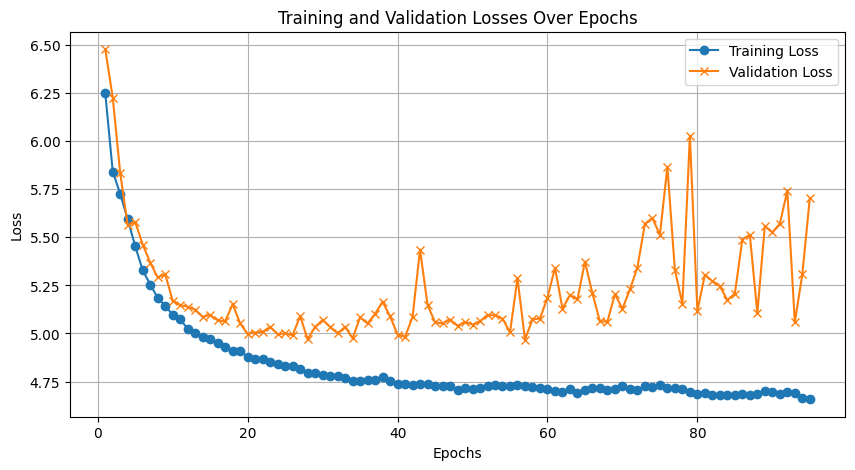

In [ ]:
epochs = list(range(1, 96))
plt.figure(figsize=(10, 5))
plt.plot(epochs, tr_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, 'final_model', '96_iterations')
torch.save(net,save_path)

In [ ]:
save_path = save_base_path + '{}_{}_{}.cp'.format(RUNNAME, 'entire_model', '101_iterations')


torch.save({'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr': lr}, save_path)

## 6. Look at outputs

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm

def visualize_segmentation_example_multilabel(net, test_data_loader):
    net.eval()  # Ensure the model is in evaluation mode.
    net.cuda()  # Ensure the model operates on the GPU.

    with torch.no_grad():  # Disable gradient computation for efficiency.
        # Iterating over the test dataset to get a single batch.
        for images, labels in tqdm(test_data_loader):

            images = images.cuda()

            # separate it out into the three labels
            label_built = labels[:, 0, :, :].unsqueeze(1)  # dimension as [batch_size, 1, height, width]
            label_pop = labels[:, 1, :, :].unsqueeze(1) # dimension as [batch_size, 1, height, width]
            label_lc = labels[:, 2, :, :] # dimension as [batch_size, height, width], i.e. removed the single dimension as cross entropy expects [batch size, height, width]

            # move them to GPU
            label_built = label_built.cuda()
            label_pop = label_pop.cuda()
            label_lc = label_lc.cuda()

            # Obtain the model's predictions.
            outputs = net(images) # [6, 25, 256, 256]
            outputs_built, outputs_pop, outputs_lc = process_outputs(outputs) # built & pop: [6, 1, 256, 256], lc: [6, 23, 256, 256]

            # Assuming the outputs of the classification task are raw logits, apply softmax to obtain probabilities.
            probs_lc = torch.softmax(outputs_lc, dim=1)

            # Convert probabilities to predicted class labels.
            predicted_masks_lc = torch.argmax(probs_lc, dim=1)

            # Move the tensors to the CPU for visualization.
            images, label_built, label_pop, label_lc, predicted_masks_lc = images.cpu(), label_built.cpu(), label_pop.cpu(), label_lc.cpu(), predicted_masks_lc.cpu()

            # Convert the first image and masks to PIL images for easy visualization.
            original_image_band1 = to_pil_image(images[0][0])
            original_image_band2 = to_pil_image(images[0][1])
            true_mask_built = to_pil_image(label_built[0].float())  # Adding channel dimension for compatibility.
            true_mask_pop = to_pil_image(label_pop[0].float())  # Adding channel dimension for compatibility.
            true_mask_lc = to_pil_image(label_lc[0].unsqueeze(0).float())  # Adding channel dimension for compatibility. # this could be an error, maybe leave the unsqueeze part away

            predicted_mask_built = to_pil_image(outputs_built[0])
            predicted_mask_pop = to_pil_image(outputs_pop[0])
            predicted_mask_lc = to_pil_image(predicted_masks_lc[0].unsqueeze(0).byte())

            # Visualization
            fig, ax = plt.subplots(2, 4, figsize=(20, 10))

            ax[0,0].imshow(original_image_band1)
            ax[0,0].set_title('Original Image Band 1')
            ax[0,0].axis('off')

            ax[1,0].imshow(original_image_band2) # second row, first column
            ax[1,0].set_title('Original Image Band 2')
            ax[1,0].axis('off')

            ax[0,1].imshow(true_mask_built)
            ax[0,1].set_title('True Mask BUILT')
            ax[0,1].axis('off')

            ax[1,1].imshow(predicted_mask_built)
            ax[1,1].set_title('Predicted Mask BUILT')
            ax[1,1].axis('off')

            ax[0,2].imshow(true_mask_pop)
            ax[0,2].set_title('True Mask POP')
            ax[0,2].axis('off')

            ax[1,2].imshow(predicted_mask_pop)
            ax[1,2].set_title('Predicted Mask POP')
            ax[1,2].axis('off')

            ax[0,3].imshow(true_mask_lc)
            ax[0,3].set_title('True Mask LC')
            ax[0,3].axis('off')

            ax[1,3].imshow(predicted_mask_lc)
            ax[1,3].set_title('Predicted Mask LC')
            ax[1,3].axis('off')

            plt.show()

            # Break after the first batch to only visualize one example.
            break


  0%|          | 0/2 [00:00<?, ?it/s]

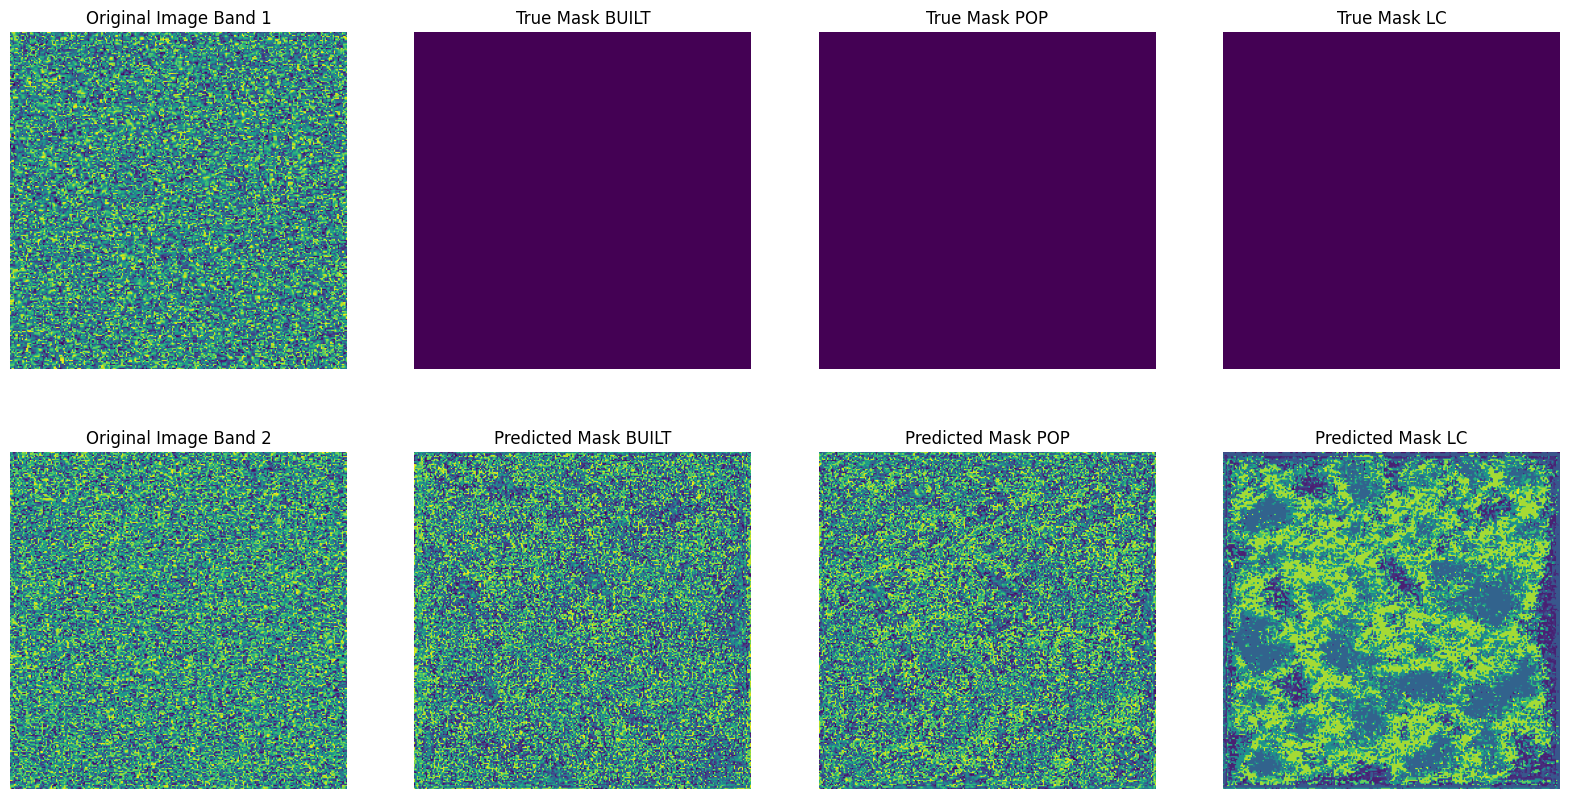

In [ ]:
visualize_segmentation_example_multilabel(net, valid_loader)